In [26]:
using Pkg 
Pkg.activate(".")

  Activating project at `~/PhD/GaussianProcessNode`


In [27]:
using Revise 
using StableRNGs, GraphPPL,ReactiveMP, RxInfer, Random, Distributions, LinearAlgebra, Plots
using ForwardDiff
using SpecialFunctions, ExponentialAction
using BenchmarkTools
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix  
import ReactiveMP: GaussHermiteCubature, approximate_meancov, InverseWishartMessage
import RxInfer: PointMassFormConstraint, call_boundaries, call_starting_point

In [28]:
using DomainSets 

In [29]:
#generate data 
function generate_cleandata(n, f_gp, c_gp)
    y=Float64[]
    obs = []
    for i=1:n
        temp = c_gp[i] * exp(f_gp[i]) 
        push!(y,temp)
    end
    return y
end

#find natural parameters of Lognormal from mean and variance
function Params2Natural_Lognormal(dist)
    μ,σ = Distributions.params(dist)
    η1 = μ/σ^2 - 1
    η2 = -1 / (2*σ^2)

    return η1, η2
end

#find mean and variance of Lognormal from natural parameters
function Natural2Params_Lognormal(η1, η2)
    μ = -(η1 + 1) / (2*(η2))
    σ = sqrt(-1/(2*(η2)))
    return μ, σ
end

#find the mean of sufficient statistics of lognormal by sampling
function estimate_MeanOfSufficient_Lognormal(dist, func, nsamples)
    samples = rand(StableRNG(1),dist,nsamples)
    Z = sum(func.(samples)) / nsamples
    E_logx = sum(func.(samples) .* log.(samples)) / (nsamples * Z)
    E_logx² = sum(func.(samples) .* (log.(samples)).^2) / (nsamples * Z)
    return E_logx, E_logx²
end

#find the mean of sufficient statistics of lognormal by gausslaguerre
function estimate_MeanOfSufficient_Lognormal_gausslaguerre(dist, func, points, w)
    WeightFunction_Z = (x) -> pdf(dist,x) * func(x) / exp(-x)
    WeightFunction_logx = (x) -> pdf(dist,x) * func(x) * log(x) / exp(-x)
    WeightFunction_logx² = (x) -> pdf(dist,x) * func(x) * (log(x))^2 / exp(-x)

    Z = dot(w,WeightFunction_Z.(points))
    E_logx = clamp(dot(w,WeightFunction_logx.(points)) / Z,tiny,huge)
    E_logx² = clamp(dot(w,WeightFunction_logx².(points)) / Z,tiny,huge)
    return E_logx, E_logx²
end

#find the mean of sufficient statistic of truncated-Normal by gausslaguerre 
function estimate_MeanOfSufficient_Normal_gausslaguerre(sign,dist, func, points, w)
    WeightFunction_Z = (x) -> pdf(dist,x*sign) * func(x*sign) / exp(-x)
    WeightFunction_x = (x) -> sign*pdf(dist,sign*x) * func(sign*x) * x / exp(-x)
    WeightFunction_x² = (x) -> pdf(dist,sign*x) * func(sign*x) * x^2 / exp(-x)

    Z = dot(w,WeightFunction_Z.(points))
    E_x = clamp(dot(w,WeightFunction_x.(points)) / Z,-Inf,huge)
    v = clamp(dot(w,WeightFunction_x².(points)) / Z - E_x^2,tiny,huge)
    return E_x, v
end



estimate_MeanOfSufficient_Normal_gausslaguerre (generic function with 1 method)

In [30]:
laguerre_points, laguerre_w = ReactiveMP.gausslaguerre(150);

In [31]:
struct MyExponential end

@node MyExponential Deterministic [ y, x ]   ## x: input,  y: output


@rule MyExponential(:y, Marginalisation) (m_x::UnivariateGaussianDistributionsFamily,) = begin 
    return LogNormal(mean(m_x), sqrt(var(m_x)))
end
@rule MyExponential(:x, Marginalisation) (m_y::LogNormal,) = begin 
    μ, σ = Distributions.params(m_y)
    return NormalMeanVariance(μ - σ^2,σ^2)
end

@marginalrule MyExponential(:x) (m_y::LogNormal, m_x::NormalMeanVariance, ) = begin 
    μ, σ = Distributions.params(m_y)
    mx_out = NormalMeanVariance(μ - σ^2,σ^2) 
    q_x = ReactiveMP.prod(ProdAnalytical(),m_x,mx_out)
    return (x = q_x)
end


In [32]:
Distributions.cov(d::Truncated{Normal{Float64}, Continuous, Float64}) = var(d)
@rule typeof(*)(:A, Marginalisation) (m_out::PointMass, m_A::UnivariateGaussianDistributionsFamily, m_in::LogNormal, meta::TinyCorrection) = begin
    mean_out = mean(m_out) 
    mean_A, var_A = mean_var(m_A)
    if mean_out > 0
        backward_A = (x) -> exp(-log(x + 1e-8) + logpdf(m_in,mean_out/(x)))
        truncated_m_in = TruncatedNormal(mean_A,sqrt(var_A),0.,Inf)
        m,v = estimate_MeanOfSufficient_Normal_gausslaguerre(1,truncated_m_in, backward_A, laguerre_points, laguerre_w)
    else
        backward_A = (x) -> exp(-log(-x -1e-8) + logpdf(m_in,mean_out/(x)))
        truncated_m_in = TruncatedNormal(mean_A,sqrt(var_A),-Inf,0)
        m,v = estimate_MeanOfSufficient_Normal_gausslaguerre(-1,truncated_m_in, backward_A, laguerre_points, laguerre_w)
    end
    ksi = m/v - mean_A/var_A
    precision = clamp(1/v - 1/var_A, tiny,huge)
    return NormalWeightedMeanPrecision(ksi,precision)
end
@rule typeof(*)(:in, Marginalisation) (m_out::PointMass, m_A::UnivariateGaussianDistributionsFamily, m_in::LogNormal, meta::TinyCorrection) = begin 
    backward_in = (x) -> exp(-log(abs(x)+1e-8) + logpdf(m_A,mean(m_out)/x))
    E_logx, E_logx² = estimate_MeanOfSufficient_Lognormal_gausslaguerre(m_in, backward_in, laguerre_points, laguerre_w)
    ## natural parameters of approximated q_in 
    η2_q_in = 1/(2*(E_logx^2 - E_logx²))
    η1_q_in = -2 * η2_q_in * E_logx - 1
    # natural parameters of m_in
    η1_m_in, η2_m_in = Params2Natural_Lognormal(m_in)
    # natural parameters of approximated backward message m_in
    η1_backwardmess = η1_q_in - η1_m_in
    η2_backwardmess = η2_q_in - η2_m_in
    if η2_backwardmess > 0
        η1_backwardmess = η1_m_in 
        η2_backwardmess = η2_m_in 
    end
    # parameters of approximated backward message m_in 
    μ, σ =  Natural2Params_Lognormal(η1_backwardmess, η2_backwardmess)
    return LogNormal(μ, σ)
end
@marginalrule typeof(*)(:A_in) (m_out::PointMass, m_A::NormalMeanVariance, m_in::LogNormal, meta::TinyCorrection) = begin 
    b_A = @call_rule typeof(*)(:A, Marginalisation) (m_out = m_out, m_A = m_A, m_in=m_in, meta=meta)
    q_A = ReactiveMP.prod(ProdAnalytical(), b_A, m_A)

    b_in = @call_rule typeof(*)(:in, Marginalisation) (m_out = m_out, m_A = m_A, m_in = m_in, meta=meta)
    q_in = ReactiveMP.prod(ProdAnalytical(),b_in,m_in)
    return (A = q_A,in = q_in, out=m_out)
end


In [33]:
function ReactiveMP.prod(::ProdAnalytical, left::LogNormal, right::LogNormal)
    η1_left, η2_left = Params2Natural_Lognormal(left)
    η1_right, η2_right = Params2Natural_Lognormal(right)

    η1 = η1_left + η1_right
    η2 = η2_left + η2_right 

    μ, σ = Natural2Params_Lognormal(η1,η2)
    return LogNormal(μ,σ)
end

In [34]:
#compute matrix A
function compute_A(logλ)
    F = [0. 1. 0.; 0. 0. 1.;-exp(logλ[1])^3 -3exp(logλ[1])^2 -3exp(logλ[1])]
    Imat = diageye(3)
    A = expv(Δt,F,Imat) + 1e-6*Imat
    return A 
end

#compute matrix P_∞
function compute_P∞(logλ)
    F = [0. 1. 0.; 0. 0. 1.;-exp(logλ[1])^3 -3exp(logλ[1])^2 -3exp(logλ[1])]
    Imat = diageye(3)
    Qc = 16/3 * exp(logλ[2])* exp(logλ[1])^5
    L = [0., 0., 1.];
    vec_P = inv(kron(Imat,F) + kron(F,Imat)+ 1e-8*diageye(9)) * vec(-L * Qc * L')
    P∞ = reshape(vec_P,3,3)  + 1e-6*Imat
    return P∞
end

#compute matrix Q
function compute_Q(logλ)
    F = [0. 1. 0.; 0. 0. 1.;-exp(logλ[1])^3 -3exp(logλ[1])^2 -3exp(logλ[1])]
    Imat = diageye(3)
    A = expv(Δt,F,Imat)
    Qc = 16/3 * exp(logλ[2])* exp(logλ[1])^5
    L = [0., 0., 1.];
    vec_P = inv(kron(Imat,F) + kron(F,Imat)+ 1e-8*diageye(9)) * vec(-L * Qc * L')
    P∞ = reshape(vec_P,3,3)
    Q = P∞ - A*P∞*A' + 1e-6*Imat
    return Q 
end

compute_Q (generic function with 1 method)

In [35]:
#create new node 
struct Matern52TransitionNode end

@node Matern52TransitionNode Stochastic [ y, x, θ ]   ## x: input,  y: output, θ: parameter 

@rule Matern52TransitionNode(:θ, Marginalisation) (m_y::MultivariateNormalDistributionsFamily,m_x::MultivariateNormalDistributionsFamily,) = begin
    μ_y, Σ_y = mean_cov(m_y)
    μ_x, Σ_x = mean_cov(m_x)


    C = (x) -> inv(compute_A(x) * Σ_x * compute_A(x)' + Σ_y + compute_Q(x))
    B = (x) -> Σ_x + inv(compute_A(x)) * (Σ_y + compute_Q(x)) * inv(compute_A(x)')

    backward_mess = (x) -> log(1/(det(compute_A(x)) * (2π)^(3/2) * det(B(x))^0.5)) - 1/2 * (μ_y - compute_A(x)*μ_x)' * C(x) * (μ_y - compute_A(x)*μ_x)

    return ContinuousMultivariateLogPdf(DomainSets.FullSpace() ^ 2,backward_mess)
end

@rule Matern52TransitionNode(:θ, Marginalisation) (q_y_x::MultivariateNormalDistributionsFamily,) = begin
    m_y_x, Σ_y_x = mean_cov(q_y_x)
    
    μ_y, μ_x = m_y_x[1:3], m_y_x[4:end]
    Σ_yy = Σ_y_x[1:3,1:3]
    Σ_xx = Σ_y_x[4:end,4:end]
    Σ_yx = Σ_y_x[1:3,4:end]
    Σ_xy = Σ_y_x[4:end,1:3]

    log_backwardmess = (θ) -> -1.5*log(2π) - 0.5*logdet(compute_Q(θ)) - 0.5 * (tr(inv(compute_Q(θ)) * compute_A(θ) * Σ_xx * compute_A(θ)') - tr(inv(compute_Q(θ)) * compute_A(θ) * Σ_xy )  -
                tr(inv(compute_Q(θ)) * Σ_yx * compute_A(θ)') + tr(inv(compute_Q(θ)) * Σ_yy) + (compute_A(θ)*μ_x - μ_y)' * inv(compute_Q(θ)) * (compute_A(θ) * μ_x - μ_y))

    return ContinuousMultivariateLogPdf(DomainSets.FullSpace() ^ 2,log_backwardmess)
end


@rule Matern52TransitionNode(:y, Marginalisation) (m_x::MultivariateNormalDistributionsFamily, q_θ::PointMass, ) = begin  
    θ = mean(q_θ)
    A = compute_A(θ)
    Q = compute_Q(θ)
    return MvNormalMeanCovariance(A*mean(m_x), A*cov(m_x)*A' + Q)
end

@rule Matern52TransitionNode(:x, Marginalisation) (m_y::MultivariateNormalDistributionsFamily, q_θ::PointMass, ) = begin
    θ = mean(q_θ)
    A = compute_A(θ)
    Q = compute_Q(θ)

    W = A' * inv(cov(m_y) + Q) * A

    return MvNormalMeanCovariance(inv(A)*mean(m_y),inv(W))
end

@marginalrule Matern52TransitionNode(:y_x) (m_y::MultivariateNormalDistributionsFamily, m_x::MultivariateNormalDistributionsFamily, q_θ::PointMass, ) = begin 
    xi_y, W_y = weightedmean_precision(m_y)
    xi_x, W_x = weightedmean_precision(m_x)
    θ = mean(q_θ)
    A = compute_A(θ)
    Q = compute_Q(θ)
    W_q = inv(Q)

    W_yx = zeros(6,6)
    Q_yx = zeros(6,6)

    W_yx[1:3,1:3] = W_y
    W_yx[4:end,4:end] = W_x 

    Q_yx[1:3,1:3] = W_q
    Q_yx[4:end,4:end] = A' * W_q * A 

    Q_yx[1:3,4:end] = -W_q * A 
    Q_yx[4:end,1:3] = -A' * W_q

    W = W_yx + Q_yx
    ξ = [xi_y;xi_x]

    return y_x = MvNormalWeightedMeanPrecision(ξ, W)
end

In [36]:
struct Matern52PriorNode end 

@node Matern52PriorNode Stochastic [ y, θ ]   ## y: output, θ: parameter 

@rule Matern52PriorNode(:y, Marginalisation) (q_θ::PointMass,) = begin
    return MvNormalMeanCovariance(zeros(3),compute_P∞(mean(q_θ)))
end

@rule Matern52PriorNode(:θ, Marginalisation) (q_y::MultivariateNormalDistributionsFamily, ) = begin 
    μ_y, Σ_y = mean_cov(q_y)
    log_backwardmess = (θ) -> -1.5 * log(2π) - 0.5 * logdet(compute_P∞(θ)) - 0.5 * (tr(inv(compute_P∞(θ)) * Σ_y) + μ_y' * inv(compute_P∞(θ)) * μ_y)
    return ContinuousMultivariateLogPdf(DomainSets.FullSpace() ^ 2,log_backwardmess)
end

# @average_energy

# @marginal

In [37]:
#create new node 
struct MyLikelihood end 
@node MyLikelihood Stochastic [ z, x, y, σ ]

@rule MyLikelihood(:z, Marginalisation) (q_x::Any, q_y::UnivariateGaussianDistributionsFamily, q_σ::PointMass,) = begin
    σ² = mean(q_σ)
    mean_x = mean(q_x)
    mean_y, var_y = mean_var(q_y)
    u_bar = exp(mean_y + var_y/2)
    
    return NormalMeanVariance(mean_x * u_bar, σ²)
end

@rule MyLikelihood(:x, Marginalisation) (q_z::Any, q_y::UnivariateGaussianDistributionsFamily, q_σ::PointMass,) = begin
    σ² = mean(q_σ)
    mean_z = mean(q_z)
    mean_y, var_y = mean_var(q_y)

    u_bar = exp(mean_y + var_y/2)
    var_u = (exp(var_y) - 1) * exp(2mean_y + var_y) 
    E_u² = var_u + u_bar^2

    return NormalMeanVariance(mean_z * u_bar / E_u², σ²/E_u²)
end

@rule MyLikelihood(:y, Marginalisation) (q_z::Any, q_x::Any, q_σ::PointMass,) = begin
    σ² = mean(q_σ)
    mean_z = mean(q_z)
    mean_x, var_x = mean_var(q_x)

    dist = NormalMeanVariance(mean_z * mean_x / (var_x + mean_x^2), σ²/(var_x + mean_x^2))
    backwardmess = (x) -> logpdf(dist, exp(x))

    return ContinuousUnivariateLogPdf(backwardmess)
end

@rule MyLikelihood(:σ, Marginalisation) (q_z::Any, q_x::Any, q_y::Any,) = begin
    return missing
end


## Learn parameters of GPAD(1)

In [38]:
## generate data 
function generate_data(n,f_gp, σ_x)
    obs = []
    for i=1:n
        x_t = σ_x * randn() 
        temp = x_t * exp(f_gp[i])
        push!(obs, temp)
    end
    return obs
end

σ_c = .5 # true frequency

N = 200; #data length
tmin,tmax = 0., 4.0
time_range = collect(range(tmin, tmax; length=N));

l_amplitude = .7 #true l_gp
σ_amplitude = 1.

## GP information
meanf = (x) -> 0.0;
kernel(θ) = σ_amplitude * with_lengthscale(Matern52Kernel(),θ)

Cov_mat = kernelmatrix(kernel(l_amplitude),time_range,time_range) + 1e-8*I;
gp_amplitude = MvNormal(meanf.(time_range), Cov_mat)
amplitude_gt = rand(StableRNG(1133),gp_amplitude)

y_data = generate_data(N,amplitude_gt,σ_c)

slicedim(dim) = (a) -> map(e -> e[dim], a);

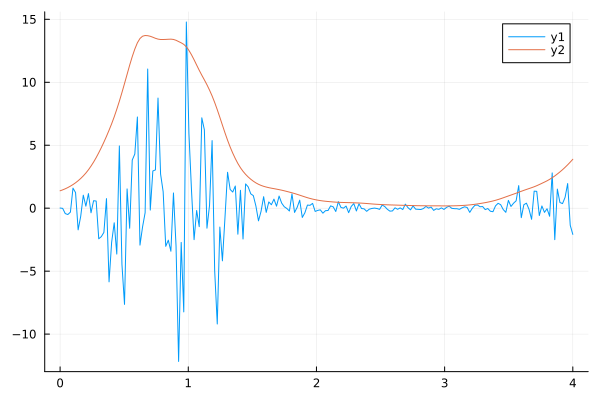

In [39]:
plot(time_range,y_data)
plot!(time_range,exp.(amplitude_gt))

In [40]:
function myGDoptimizer(func, init, η; niter = 1000)
    grad_func = let f = func 
        (x) -> ForwardDiff.gradient(f, x)
    end
    opt_val = init 
    for i=1:niter 
        func_prev = func(opt_val)
        grad = grad_func(opt_val)
        opt_val -= η*grad 
        if abs(func_prev - func(opt_val)) < 1e-12
            return opt_val
        end 
    end
    return opt_val
end

function myMomentumGDoptimizer(func, init_val,init_v,ρ,η; niter=100)
    grad_func = let f = func 
        (x) -> ForwardDiff.gradient(f, x)
    end
    opt_val = init_val 
    v = init_v #momentum 
    for i=1:niter 
        func_prev = func(opt_val)
        grad = grad_func(opt_val)
        v *= ρ
        v += η*grad 
        opt_val -= v 
        if abs(func_prev - func(opt_val)) < 1e-12
            return opt_val
        end 
    end 
    return opt_val
end

# function myConjugateGDoptimizer(func, init,α, η; niter = 1000)
#     grad_func = let f = func 
#         (x) -> ForwardDiff.gradient(f, x)
#     end
#     g_prev = grad_func(init)
#     opt_val = init
#     d = -g_prev
#     for i=1:niter 
#         func_prev = func(opt_val)
#         opt_val += α * d
#         g_new = grad_func(opt_val)
#         η = -1/(norm(d) * min(η,norm(g_new)))
#         β_tilde_new = 1/(d' * (g_new - g_prev)) * ((g_new - g_prev) - 2 * d * norm(g_new - g_prev)^2/(d' * (g_new-g_prev)))' * g_new
#         β_new = max(η, β_tilde_new)
#         d = -g_new + β_new * d
#         g_prev = g_new 
#         if abs(func_prev - func(opt_val)) < 1e-8
#             return opt_val
#         end
#     end
#     return opt_val 
# end

function myADAMoptimizer(func, init_value, η; β1 = 0.9, β2 = 0.999, ϵ = 1e-8,niter=10)
    grad_func = let f = func 
        (x) -> ForwardDiff.gradient(f, x)
    end
    opt_val = init_value
    m_new = [0,0]
    v_new = [0,0]
    for i=1:niter 
        func_prev = func(opt_val)
        g = grad_func(opt_val)
        m_new *= β1  
        m_new += (1 - β1) * g 

        v_new *= β2 
        v_new += (1-β2) * g.^2
        
        m_hat = m_new ./ (1 - β1^i)
        v_hat = v_new ./ (1 - β2^i)
        opt_val -= η * m_hat .* g ./ (sqrt.(v_hat) .+ ϵ)
        if abs(func_prev - func(opt_val)) < 1e-12
            return opt_val
        end
    end
    return opt_val
end

myADAMoptimizer (generic function with 1 method)

In [41]:
@model function GPAD_1(n, amplitude_lλ, H::ConstVariable)
    y = datavar(Float64,n)
    f = randomvar(n)
    z = randomvar(n)
    d = randomvar(n)
    g = randomvar(n)
    
    amplitude_logλ ~ MvNormalMeanCovariance(amplitude_lλ, 20*diageye(2))
    β ~ GammaShapeRate(0.01,0.01)
    γ ~ GammaShapeRate(0.01,0.01)
    f_0 ~ Matern52PriorNode(amplitude_logλ)
    d_0 ~ NormalMeanVariance(0.,50.)
    f_prev = f_0
    d_prev = d_0
    for i=1:n 
        f[i] ~ Matern52TransitionNode(f_prev, amplitude_logλ) where { q = q(f[i],f_prev)q(amplitude_logλ) } 
        z[i] ~ NormalMeanPrecision(dot(H , f[i]), γ) where { q = MeanField() }
        g[i] ~ MyExponential(z[i])

        d[i] ~ NormalMeanPrecision(d_prev, β) where { q = q(d[i],d_prev)q(β)} 

        # y[i] ~ MyLikelihood(d[i],z[i],0.01) where { q = MeanField() }
        y[i] ~ (*)(d[i],g[i]) where {meta = TinyCorrection(), pipeline = RequireMessage(A = NormalMeanPrecision(0., 10.),in = LogNormal(0,4.))}
        f_prev = f[i]
        d_prev = d[i]
    end
end

In [42]:
@constraints function GPAD_1_constraints()  
    q(amplitude_logλ,f_0) = q(amplitude_logλ)q(f_0)
    q(amplitude_logλ) :: PointMass(starting_point = (args...) -> amplitude_logλ_init)
end

GPAD_1_constraints (generic function with 1 method)

In [43]:
function RxInfer.default_point_mass_form_constraint_optimizer(::Type{Multivariate}, ::Type{Continuous}, constraint::PointMassFormConstraint, distribution)
    target = let distribution = distribution
        (x) -> -logpdf(distribution, x)
    end
    init_val = call_starting_point(constraint, distribution) 
    # result = myMomentumGDoptimizer(target,init_val,[0.,0.], 0.1, 0.0001)
    result = myADAMoptimizer(target,init_val, 0.0001)
    return PointMass(result)
end

In [44]:
Δt = time_range[2] - time_range[1]; # time difference

amplitude_θ_init = [.4,1.5]; # [l_Amplitude, σ²_amplitude]

amplitude_logλ_init = [log(sqrt(5)/amplitude_θ_init[1]), log(amplitude_θ_init[2])];

H = [1., 0., 0.];

In [45]:
function ReactiveMP.prod(::ProdAnalytical, left::UnivariateGaussianDistributionsFamily, right::ContinuousUnivariateLogPdf)
    backwardmess = (x) -> exp(right.logpdf(x))
    m,v = approximate_meancov(ghcubature(21),backwardmess, left)
    return NormalMeanVariance(m,v)
end

In [46]:
nits = 100
iresult = inference(
    model = GPAD_1(N,amplitude_logλ_init,H),
    initmarginals = (amplitude_logλ = PointMass(amplitude_logλ_init),β = GammaShapeRate(0.01,0.01),
           z = NormalMeanVariance(0,1.),γ = GammaShapeRate(0.01,0.01) ),
    constraints = GPAD_1_constraints(),
    iterations = nits, 
    data  = (y = y_data,),
    returnvars = (f = KeepLast(), amplitude_logλ = KeepLast(), β = KeepLast(),),
    options = (limit_stack_depth=400,),
    free_energy = false,
    showprogress = false
)

Inference results:
  Posteriors       | available for (f, amplitude_logλ, β)


In [47]:
amp_logλ =  mean(iresult.posteriors[:amplitude_logλ])
l_amp = sqrt(5) / (exp(amp_logλ[1]))
σ_amp = exp(amp_logλ[2])

println("l_amp = $l_amp, σ_amp = $σ_amp")
println("true l_amp = $l_amplitude, true σ_amp = $σ_amplitude")
println("true l_amp = $l_amplitude")
println("true σ_amp = $σ_amplitude")

l_amp = 0.49369454371367544, σ_amp = 1.4411942437099747
true l_amp = 0.7, true σ_amp = 1.0
true l_amp = 0.7
true σ_amp = 1.0


In [48]:
β_pos =  mean(iresult.posteriors[:β])

println("approx β = $β_pos")
println("gt β= $(1/σ_c)")

approx β = 0.073403443570651
gt β= 2.0


In [49]:
mgp = mean.(iresult.posteriors[:f]) |> slicedim(1)
vgp = var.(iresult.posteriors[:f]) |> slicedim(1)
expvgp = exp.( mgp .+ vgp)
expmgp = exp.(mgp .+ vgp./2);

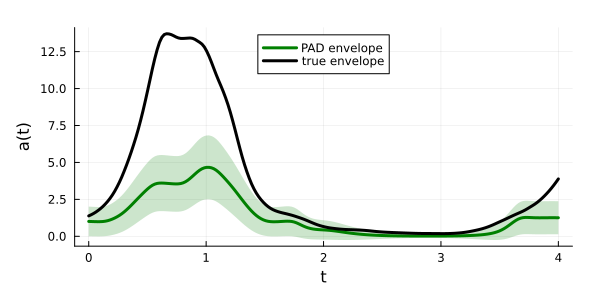

In [50]:
plot(time_range,expmgp,ribbon=sqrt.(expvgp),linewidth=3.0,label="PAD envelope",color=:green,fillalpha=0.2, size = (600, 300),margin=5Plots.mm)
plot!(time_range,exp.(amplitude_gt), label="true envelope",linewidth=3.0,color=:black,legend=:top)
ylabel!("a(t)")
xlabel!("t")